# Predicción de Riesgo de Default

## Se utilizan los siguientes datos https://www.kaggle.com/c/home-credit-default-risk/data

### Descripción:

Home Credit es una organización que provee créditos hipotecarios. Para decidir a quien entrega un crédito, se suelen considerar distintas variables asociadas al solicitante. Este problema corresponde a uno supervisado (se tienen las "etiquetas" de los resultados que se quieren predecir) y de clasificación (el target toma valor 1 o 0 y se requiere de un "threshold" o límite). 

Dentro de este tipo de problemas existen métricas necesarias e importantes para seleccionar el "mejor modelo".

##### Precision:  
Muestra el porcentaje de positivos predichos sobre total de predicciones positivas. De las predichas como positivas, cuántas realmente lo fueron. Corresponde a una buena medida cuando el costo del Falso Positivo es alto (ej. Spam detection. El usuario puede perder correos importantes)

\begin{equation}
\frac{True Positive}{True Positive + False Positive}
\end{equation}
##### Recall / Exhaustividad:
Muestra el porcentaje de positivos predichos sobre el total de positivos. Corresponde a una buena medida cuando el costo del Falso Negativo es alto (ej. enfermedad contagiosa, terrorista, fraude)

\begin{equation}
\frac{True Positive}{True Positive + False Negative}
\end{equation}
##### Accuracy:
Muestra el porcentaje de predicciones bien hechas sobre el total datos.

\begin{equation}
\frac{True Positive + True Negative}{True Positive + True Negative + False Positive + False Negative}
\end{equation}
##### F1 Score:
\begin{equation}
\ 2*\frac{Precision*Recall}{Precision + Recall}
\end{equation}
##### Receiver Operation Characteristic - Area Under the Curve (ROC AUC):

ROC: Corresponde al gráfico que muestra la relación entre el ratio (cantidad sobre total) de True Positives y False Positives de un determinado modelo al ir cambiando el "threshold". En general se contrastan distintos modelos.

AUC: Corresponde al área bajo el ROC. Un modelo que predice aleatoriamente uniforme tendrá un AUC 0.5. 

Cuando se evalúa un modelo con ROC AUC no se generan predicciones 0 o 1 sino que se generan predicciones como probabilidades entre 0 y 1. Cuando se tienen clases desbalanceadas la métrica Accuaracy no es muy útil, si se quisiera predecir si una persona es terrorista se podría decir que el  99,9% de los casos NO es terrorista y se tendría un Accuaracy alto, el Recall sería 0. Pero el costo de equivocarse es muy alto, por lo tanto se requieren métricas como ROC AUC

### Endogeneidad: Cuando existe correlación entre una variable independiente y el error .

#### *La endogeneidad puede surgir como resultado de un error de medición, autorregresión con autocorrelación de errores, simultaneidad y variables omitidas.*
* El problema de la endogeneidad se produce cuando la variable independiente se correlaciona con el término de error en una regresión. Esto implica que el coeficiente de regresión por Mínimos cuadrados ordinarios (MCO) va a estar sesgado, sin embargo, si la correlación no es contemporánea, entonces aún puede ser consistente. Hay muchos métodos para superar esto, incluyendo Variables instrumentales y corrección de selección de Heckman.

Por ejemplo, en un simple modelo de oferta y demanda, al momento de predecir la cantidad demandada en equilibrio, el precio es endógeno porque los productores cambian su precio en función de la demanda y los consumidores cambian su demanda en respuesta a los precios. En este caso, se dice que la variable de precio tiene endogeneidad total una vez conocidas las curvas de demanda y oferta. En contraste, un cambio en el consumo gustos o preferencias sería un cambio exógeno en la curva de demanda (Fuente: https://es.wikipedia.org/wiki/Endogeneidad_(econom%C3%ADa))



### Variable instrumental (VI):  Un instrumento es una variable que no pertenecen en sí en la ecuación explicativa y se correlaciona con las variables explicativas endógenas, condicionada a las otras variables.

En modelos lineales, el uso de VI tiene dos requisitos:

* El instrumento debe estar correlacionado con las variables explicativas endógenas, condicionada a las otras variables.
* El instrumento no puede estar correlacionado con el término de error en la ecuación explicativa, es decir, el instrumento no puede sufrir el mismo problema que la variable original que pretende predecir.

In [1]:
import pandas as pd
infor = pd.read_csv('HomeCredit_columns_description.csv', header=0 , sep=',', encoding='latin')

In [2]:
infor['Description'].loc[1]

'Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)'

Dada la definición de "Target varaible" se pueden entender como serían los casos de Falso Negativo y Falso Positivo:

* Falso Negativo : Predecir 0 (No tendrá dificultades) y erróneamente (Tiene dificultades). Pierdo total plata prestada.

* Falso Positivo : Predecir 1 (Tendrá dificultades) y erróneamente (No tiene difucultades). Pierdo margen por crédito.

Para optar por Recall o Precision, es necesario determinar qué costo es superior. Por el momento se debiera usar F1 Score.

In [3]:
df = pd.read_csv('application_train.csv', header=0, sep=',')

In [4]:
df.head(6)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
5,100008,0,Cash loans,M,N,Y,0,99000.0,490495.5,27517.5,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0


In [5]:
import matplotlib.pyplot as plt
df['TARGET'].plot.hist()
plt.show()

<Figure size 640x480 with 1 Axes>

In [6]:
df['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

### *Imbalanced Classes Treatment*

Most machine learning algorithms work best when the number of samples in each class are about equal. This is because most algorithms are designed to maximize accuracy and reduce error.

Para resolver el problema anterior se sugieren 5 métodos:

* Utilizar métricas como recall, precision y f1-score. 
* Probar distintos modelos de machine learning. Por ejemplo, los arboles de decisión tienen un buen desempeño frente a clases desproporcionadas(Random Forest). 
* Resamplear-Agregar más datos para la clase en minoría.
* Resamplear-Remover datos de la clase en mayoría.
* Generar muestras artificiales o sintéticas (SMOTE or Synthetic Minority Oversampling Technique).

Fuente: https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18

In [7]:
nulos = df.isnull().sum()
missingtable = pd.concat([nulos,round(nulos/len(df),3)*100],axis=1)
missingtable = missingtable.rename(columns={0:'missing',1:'porcentaje'})
missingtable = missingtable[missingtable['missing']>0].sort_values(by='missing',ascending=False)
missingtable

,missing,porcentaje
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


In [8]:
df.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

Se toman las variables categóricas para ver cuantas categorías tiene cada una.

In [9]:
df.select_dtypes('object').nunique()

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

Para trabajar con variables categóricas es necesario pasarlas a números (encoding). En general, los modelos de machine learning no están capacitados para trabajar con categorías que no sean números (a execepción de LightGBM). Para resolver el problema anterior, se conocen dos métodos:

* One Hot Encoding : Se crea una nueva columna por categoría con valor 1 o 0 si corresponde (resulta en n-1 columnas).
* Label Encoding : Se asignan valores de 1 a n a cada categoría (resulta en sólo una columna)

PENDIENTE LO DE ARRIBA

### Clustering analysis (Unsupervised learning)

#### K-Means:
###### Choosing the number of clusters :<br>
We graph the relationship between the number of clusters and Within Cluster Sum of Squares (WCSS) then we select the number of clusters where the change in WCSS begins to level off (elbow method). WCSS is defined as the sum of the squared distance between each member of the cluster and its centroid.

https://towardsdatascience.com/machine-learning-algorithms-part-9-k-means-example-in-python-f2ad05ed5203

In [80]:
from sklearn.cluster import KMeans
wcss = []
X = df.drop(columns=['TARGET','SK_ID_CURR']).select_dtypes(exclude='object')
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [58]:
infor[infor['Table']=='application_{train|test}.csv'].loc[:,'Row':'Description']

,Row,Description
0,SK_ID_CURR,ID of loan in our sample
1,TARGET,Target variable (1 - client with payment diffi...
2,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving
3,CODE_GENDER,Gender of the client
4,FLAG_OWN_CAR,Flag if the client owns a car
5,FLAG_OWN_REALTY,Flag if client owns a house or flat
6,CNT_CHILDREN,Number of children the client has
7,AMT_INCOME_TOTAL,Income of the client
8,AMT_CREDIT,Credit amount of the loan
9,AMT_ANNUITY,Loan annuity


In [72]:
enumerate(data_cols)

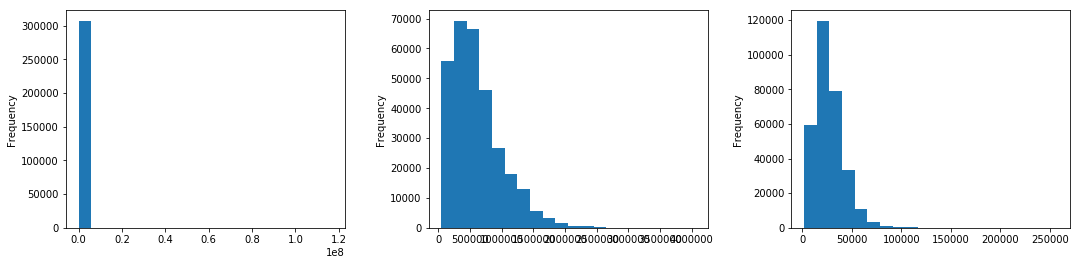

In [74]:
data_cols = ['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY']
fig, axes = plt.subplots(1,3,figsize=(18,4))
plt.subplots_adjust(wspace=.3)

for i, col in enumerate(data_cols):
    df[col].plot.hist(ax=axes[i],bins=20)


In [41]:
len(df[df['AMT_INCOME_TOTAL']>10**8])
df[df['AMT_INCOME_TOTAL']>10**8].index
#df.loc[12840]

Int64Index([12840], dtype='int64')

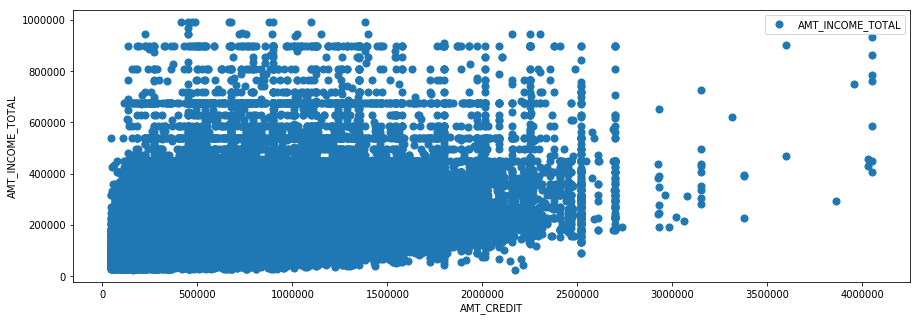

In [53]:
fig, ax = plt.subplots(figsize=(15,5))
dataplot = df.drop(df[df['AMT_INCOME_TOTAL']>10**6].index)
ax.scatter(dataplot['AMT_CREDIT'],dataplot['AMT_INCOME_TOTAL'],s=50)
ax.set_xlabel('AMT_CREDIT')
ax.set_ylabel('AMT_INCOME_TOTAL')
plt.legend()